In [1]:
#Libraries
import pandas as pd
import pandas as pd
from surprise import Reader, Dataset, KNNBasic, accuracy, PredictionImpossible
from collections import defaultdict
from surprise.model_selection import KFold
from random import shuffle
import matplotlib.pyplot as plt

#Importing the data
data = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/downsampled_df_random.csv')
data.head()

,userId,wine,rate
0,976ec198-048f-405c-b6e6-b17ee1db1139,Nebbiolo d alba superiore,4
1,4eb7031c-da00-48f4-bc7f-0a1f1eda7cab,Malvasia legno,3
2,13016d41-00bd-411c-83f5-2b95691696b7,Bianco,3
3,13016d41-00bd-411c-83f5-2b95691696b7,Cabernet Franc,3
4,0a23a07a-8556-4ef6-85ee-d996f8ed619e,Talò Primitivo - Merlot,4


In [2]:
#metrics
metrics_df = pd.DataFrame(
    columns=['Index','Model','Metric','Optimizer','User_based',
             'RMSE','MAE','MSE', 'Precision', 'Recall', 'Accuracy'])
print(metrics_df)

Empty DataFrame
Columns: [Index, Model, Metric, Optimizer, User_based, RMSE, MAE, MSE, Precision, Recall, Accuracy]
Index: []


In [3]:
class Knn (KNNBasic):
    def __init__(self, sim_options={}, bsl_options={}):
        KNNBasic.__init__(self, sim_options=sim_options, bsl_options=bsl_options)
    
    def create_reader(self, data):
        reader = Reader(rating_scale=(1, 5))
        self.data = Dataset.load_from_df(data[['userId', 'wine', 'rate']], reader)

    def fit (self):
        '''Divide the data into train and test manually '''
        #Frist shuffle the data
        raw_ratings = self.data.raw_ratings
        shuffle(raw_ratings)
        
        #75% of the data for training and the rest for testing
        threshold = int(.80 * len(raw_ratings))
        train_raw_ratings = raw_ratings[:threshold]
        test_raw_ratings = raw_ratings[threshold:]
        
        #Update the data object with train raw ratings
        self.data.raw_ratings = train_raw_ratings
        
        #Define a cross-validation iterator
        kf = KFold(n_splits=5, shuffle= True, random_state=42)
        
        train_rmse_list = []
        test_rmse_list = []
        
        for trainset_fold, testset_fold in kf.split(self.data):
            #Train and test algorithm.
            KNNBasic.fit(self, trainset_fold)
            train_prediction = KNNBasic.test(self, trainset_fold.build_testset())
            prediction = KNNBasic.test(self, testset_fold)

            #Error on training
            train_rmse = accuracy.rmse(train_prediction)
            train_rmse_list.append(train_rmse)

            #Error on testing
            test_rmse = accuracy.rmse(prediction)
            test_rmse_list.append(test_rmse)

        avg_train_rmse = sum(train_rmse_list) / len(train_rmse_list)
        avg_test_rmse = sum(test_rmse_list) / len(test_rmse_list)
        print("###############################################")
        print("The Results are: \n")
        print(f"Average RMSE on Training Set: {avg_train_rmse}")
        print(f"Average RMSE on Test Set: {avg_test_rmse}")

        #Predict ratings for all pairs (u, i) that are NOT in the training set.
        #Update the data object with test raw ratings
        self.data.raw_ratings = test_raw_ratings
        #adapting the Testset to be compatible with Surprise
        testset = self.data.construct_testset(self.data.raw_ratings)
        #Predicting the ratings for testset
        predictions = KNNBasic.test(self, testset)
        #RMSE
        test_rmse = accuracy.rmse(predictions)
        print(f"RMSE on Test Set on UNSEEN DATA is RMSE, : {test_rmse}")

        self.sim = self.compute_similarities()
        self.bu, self.bi = self.compute_baselines()
        return predictions
    
    def get_user_name(self, uid):
        """Return the name of a user from their id.
        Args:
            uid(int): The raw id of the user.
        Returns:
            The name of the user.
        """
        return self.trainset.to_raw_uid(uid)
    
    def get_item_name(self, iid):
        """Return the name of an item from their id.
        Args:
            iid(int): The raw id of the item.
        Returns:
            The name of the item.
        """
        return self.trainset.to_raw_iid(iid)
    
    def get_neighbors_uid(self, user_id, k=10):
        neighbor_ids = self.get_neighbors(user_id, k=10)
        neighbor_names = [self.get_user_name(uid) for uid in neighbor_ids]
        return neighbor_names
    def get_neighbors_iid(self, item_id, k=10):
        neighbor_ids = self.get_neighbors(item_id, k=10)
        neighbor_names = [self.get_item_name(iid) for iid in neighbor_ids]
        return neighbor_names
        
    def get_top_n_for_user(self, predictions,user_id, n=10):
        """Return the top-N recommendation for a user from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            n(int): The number of recommendation to output for each user. Default
                is 10.

        Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
            [(raw item id, rating estimation), ...] of size n.
        """

        # First map the predictions to each user.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if uid == user_id:
                top_n[uid].append((iid, est))

        # Then sort the predictions for the user and retrieve the k highest ones.
        user_ratings = top_n[user_id]
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[user_id] = user_ratings[:n]

        return top_n[user_id]
    
    def get_top_n_users_for_item(self, predictions, item_id, n=10):
        """Return the top-N users for a specific item from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            item_id: The id of the item for which to get the top-N users.
            n(int): The number of users to output for the item. Default is 10.

        Returns:
        A list of tuples:
            [(raw user id, rating estimation), ...] of size n.
        """

        # First map the predictions to each item.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if iid == item_id:
                top_n[iid].append((uid, est))

        # Then sort the predictions for the item and retrieve the k highest ones.
        item_ratings = top_n[item_id]
        item_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[item_id] = item_ratings[:n]

        return top_n[item_id]

    def estimated(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")
        
        #Compute similarities between u and v, where v describes all other
        #users that have also rated item i.
        neighbors = [(v, self.sim[u, v]) for (v, r) in self.trainset.ir[i]]
        # Sort these neighbors by similarity
        neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)

        print("The 5 nearest neighbors of user", str(u), "are:")
        for v, sim_uv in neighbors[:5]:
            print(f"user {v} with sim {sim_uv:1.15f}")

        # ... Aaaaand return the baseline estimate anyway ;)
        bsl = self.trainset.global_mean + self.bu[u] + self.bi[i]
        return print(f"And the baseline estimate is: {bsl}")
    
    def get_Iu(self, uid):
        """Return the number of items rated by given user
        args:
          uid: the id of the user
        returns:
          the number of items rated by the user
        """
        try:
            return len(self.trainset.ur[self.trainset.to_inner_uid(uid)])
        except ValueError:  # user was not part of the trainset
            return 0

    def get_Ui(self, iid):
        """Return the number of users that have rated given item
        args:
          iid: the raw id of the item
        returns:
          the number of users that have rated the item.
        """
        try:
            return len(self.trainset.ir[self.trainset.to_inner_iid(iid)])
        except ValueError:
            return 0

    def inspect_predictions(self, predictions):
        print(f"uid means the user id and iid means the wine id\n")
        print(f"rui means the actual rating and est means the estimated rating\n")
        print(f"err means the error between the actual and the estimated rating\n")
        print(f"Iu means the number of items rated by given user\n")
        print(f"Ui means the number of users that have rated given item\n")
        # Create a dataframe with the predictions
        df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
        df_pred['Iu'] = df_pred.uid.apply(self.get_Iu)
        df_pred['Ui'] = df_pred.iid.apply(self.get_Ui)
        df_pred['err'] = abs(df_pred.est - df_pred.rui)
        return df_pred
    
    def get_accuracy(self, predictions, k=10, threshold=3.5):
        #Compute RMSE
        rmse = accuracy.rmse(predictions, verbose=True)
        #Compute MAE
        mae = accuracy.mae(predictions, verbose=True)
        # Compute MSE
        mse = accuracy.mse(predictions, verbose=True)

        #Compute precision and recall
        precisions, recalls = self.precision_recall_at_k(predictions, k=k, threshold=threshold)

        #Precision and recall can then be averaged over all users
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}')

        #Count correct predictions
        correct = 0
        for uid, iid, true_r, est, _ in predictions:
            if round(est) == round(true_r):
                correct += 1

        #Compute accuracy
        accuracy_percentage = correct / len(predictions)
        accuracy_percentage = accuracy_percentage * 100
        print(f"the acc is {accuracy_percentage:.2f}")

        #Return a dictionary with the metrics
        return {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy_percentage}
        
    @staticmethod 
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        """Return precision and recall at k metrics for each user"""
        # First map the predictions to each user.
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return precisions, recalls

## Knn SGD

* knn cosine, user based

In [4]:
knn = Knn(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn.create_reader(data)
predictions = knn.fit()
#acc
metrics = knn.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 1
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3642
RMSE: 0.9847
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3951
RMSE: 0.9004
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3849
RMSE: 0.9616
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3915
RMSE: 0.9042
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3781
RMSE: 0.9912
###############################################
The Results are: 

Average RMSE on Training Set: 0.3827485698946126
Average RMSE on Test Set: 0.948440193934719
RMSE: 0.9186
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9185729267559992
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.9186
MAE:  0.6917
MSE: 0.8438
Precision: 0.68
Recall: 0.74
the acc is 50.42


/tmp/ipykernel_17363/161991997.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn cosine, item based

In [5]:
knn2 = Knn(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn2.create_reader(data)
predictions = knn2.fit()
#acc
metrics = knn2.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 2
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6308
RMSE: 0.8398
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6189
RMSE: 0.9778
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6255
RMSE: 0.9329
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6450
RMSE: 0.9785
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6315
RMSE: 1.0697
###############################################
The Results are: 

Average RMSE on Training Set: 0.6303485815525568
Average RMSE on Test Set: 0.9597439205120801
RMSE: 0.9978
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9977597906159836
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.9978
MAE:  0.8086
MSE: 0.9955
Precision: 0.64
Recall: 0.71
the acc is 38.66


/tmp/ipykernel_17363/3130600781.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17363/3130600781.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn mean squared difference, user based

In [6]:
knn3 = Knn(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn3.create_reader(data)
predictions = knn3.fit()
#acc
metrics = knn3.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 3
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2553
RMSE: 0.9949
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2292
RMSE: 0.9336
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2588
RMSE: 0.7499
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2197
RMSE: 0.9483
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2276
RMSE: 1.0900
###############################################
The Results are: 

Average RMSE on Training Set: 0.2381213481817035
Average RMSE on Test Set: 0.9433434600704456
RMSE: 0.9311
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9310609712915576
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.9311
MAE:  0.7697
MSE: 0.8669
Precision: 0.66
Recall: 0.74
the acc is 45.38


/tmp/ipykernel_17363/3369594395.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17363/3369594395.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn mean squared diference, item based

In [7]:
knn4 = Knn(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn4.create_reader(data)
predictions = knn4.fit()
#acc
metrics = knn4.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 4
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4073
RMSE: 0.9465
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3348
RMSE: 1.0666
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4038
RMSE: 0.8818
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4044
RMSE: 0.9158
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3856
RMSE: 0.9450
###############################################
The Results are: 

Average RMSE on Training Set: 0.3871699324736103
Average RMSE on Test Set: 0.9511395167937128
RMSE: 1.0371
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0371286296737223
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.0371
MAE:  0.8572
MSE: 1.0756
Precision: 0.70
Recall: 0.77
the acc is 38.66


/tmp/ipykernel_17363/1900242280.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17363/1900242280.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn pearson, user based

In [8]:
knn5 = Knn(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn5.create_reader(data)
predictions = knn5.fit()
#acc
metrics = knn5.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 5
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1408
RMSE: 0.8953
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1440
RMSE: 0.9336
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1718
RMSE: 0.9640
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1345
RMSE: 0.9617
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1467
RMSE: 0.9412
###############################################
The Results are: 

Average RMSE on Training Set: 0.14756140694858738
Average RMSE on Test Set: 0.9391961655237209
RMSE: 0.9596
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9595732703496724
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.9596
MAE:  0.7910
MSE: 0.9208
Precision: 0.74
Recall: 0.81
the acc is 42.86


/tmp/ipykernel_17363/3339916766.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17363/3339916766.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn pearson, item based

In [9]:
knn6 = Knn(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn6.create_reader(data)
predictions = knn6.fit()
#acc
metrics = knn6.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 6
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1850
RMSE: 0.9907
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1419
RMSE: 1.0313
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2544
RMSE: 0.9421
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1737
RMSE: 0.9811
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2092
RMSE: 1.0797
###############################################
The Results are: 

Average RMSE on Training Set: 0.1928291026087121
Average RMSE on Test Set: 1.0049619954845095
RMSE: 0.8525
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8524705871005683
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.8525
MAE:  0.6927
MSE: 0.7267
Precision: 0.67
Recall: 0.74
the acc is 46.22


/tmp/ipykernel_17363/3614094042.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17363/3614094042.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn (shrunk) pearson correlation coefficient, user based

In [10]:
knn7 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn7.create_reader(data)
predictions = knn7.fit()
#acc
metrics = knn7.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 7
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1891
RMSE: 0.9936
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1835
RMSE: 0.9230
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0662
RMSE: 1.0172
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1126
RMSE: 0.8919
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1823
RMSE: 0.9677
###############################################
The Results are: 

Average RMSE on Training Set: 0.14675252708635142
Average RMSE on Test Set: 0.9586978484792494
RMSE: 0.9709
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9709219531556629
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_17363/3960392171.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17363/3960392171.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn (shrunk) pearson correlation coefficient, item based

In [11]:
knn8 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn8.create_reader(data)
predictions = knn8.fit()
#acc
metrics = knn8.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 8
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1068
RMSE: 0.9551
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1586
RMSE: 0.9346
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1479
RMSE: 0.9604
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1229
RMSE: 0.9697
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1324
RMSE: 0.9195
###############################################
The Results are: 

Average RMSE on Training Set: 0.1337249555566497
Average RMSE on Test Set: 0.9478565733610637
RMSE: 1.0071
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0070673763740923
Computing the pearson_baseline similarity matrix.

/tmp/ipykernel_17363/3933834523.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17363/3933834523.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


## Knn Alternating Least Squares (ALS)

* knn cosine, user based

In [12]:
knn9 = Knn(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn9.create_reader(data)
predictions = knn9.fit()
#acc
metrics = knn9.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 9
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3973
RMSE: 0.9105
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.4027
RMSE: 0.9494


/tmp/ipykernel_17363/3513140556.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17363/3513140556.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.4031
RMSE: 1.0187
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.4247
RMSE: 0.9161
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3685
RMSE: 0.9658
###############################################
The Results are: 

Average RMSE on Training Set: 0.39925105617993906
Average RMSE on Test Set: 0.9521188060022423
RMSE: 0.8973
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8973416644737404
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.8973
MAE:  0.7291
MSE: 0.8052
Precision: 0.72
Recall: 0.79
the acc is 45.38


* knn cosine, item based

In [13]:
knn10 = Knn(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn10.create_reader(data)
predictions = knn10.fit()
#acc
metrics = knn10.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 10
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6056
RMSE: 0.9979
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6174
RMSE: 1.0064
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6426
RMSE: 0.8074
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6135
RMSE: 1.0615
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6286
RMSE: 0.9771
###############################################
The Results are: 

Average RMSE on Training Set: 0.6215172861093151
Average RMSE on Test Set: 0.9700451676594595
RMSE: 0.9550
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9549699991903112
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.9550
MAE:  0.7874
MSE: 0.9120
Precision: 0.69
Recall: 0.74
the acc is 42.02


/tmp/ipykernel_17363/857205367.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17363/857205367.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn mean squared difference, user based

In [14]:
knn11 = Knn(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn11.create_reader(data)
predictions = knn11.fit()
#acc
metrics = knn11.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 11
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1992
RMSE: 1.0005
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2310
RMSE: 0.9695
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2409
RMSE: 0.8847
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2490
RMSE: 0.8333
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2324
RMSE: 1.0012
###############################################
The Results are: 

Average RMSE on Training Set: 0.23050209958017742
Average RMSE on Test Set: 0.9378142573192882
RMSE: 0.9972
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9972357779370079
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.9972
MAE:  0.8025
MSE: 0.9945
Precision: 0.70
Recall: 0.82
the acc is 41.18


/tmp/ipykernel_17363/1804258722.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17363/1804258722.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn mean squared difference, item based

In [15]:
knn12 = Knn(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn12.create_reader(data)
predictions = knn12.fit()
#acc
metrics = knn12.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 12
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3706
RMSE: 0.9438
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3818
RMSE: 0.9130
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3581
RMSE: 1.0027
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3876
RMSE: 0.9516
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3698
RMSE: 0.9885
###############################################
The Results are: 

Average RMSE on Training Set: 0.3735566120982008
Average RMSE on Test Set: 0.9599188818717799
RMSE: 0.8906
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8905655016662847
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.8906
MAE:  0.7038
MSE: 0.7931
Precision: 0.72
Recall: 0.80
the acc is 50.42


/tmp/ipykernel_17363/262444695.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17363/262444695.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn pearson correlation coefficient, user based

In [16]:
knn13 = Knn(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn13.create_reader(data)
predictions = knn13.fit()
#acc
metrics = knn13.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 13
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0972
RMSE: 1.0049
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1668
RMSE: 0.8846
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1894
RMSE: 0.9994
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2076
RMSE: 0.9333
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1973
RMSE: 1.0092
###############################################
The Results are: 

Average RMSE on Training Set: 0.17167354699200638
Average RMSE on Test Set: 0.9662872127542244
RMSE: 0.9441
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9441103104002585
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.9441
MAE:  0.7927
MSE: 0.8913
Precision: 0.60
Recall: 0.68
the acc is 38.66


/tmp/ipykernel_17363/1092855449.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17363/1092855449.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn pearson correlation coefficient, item based

In [17]:
knn14 = Knn(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn14.create_reader(data)
predictions = knn14.fit()
#acc
metrics = knn14.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 14
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1004
RMSE: 1.0332
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1744
RMSE: 1.1078
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2388
RMSE: 0.8970
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1737
RMSE: 0.8565
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1773
RMSE: 0.9737
###############################################
The Results are: 

Average RMSE on Training Set: 0.17291529490564414
Average RMSE on Test Set: 0.9736287663743491
RMSE: 0.9239
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9239133059261827
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.9239
MAE:  0.7627
MSE: 0.8536
Precision: 0.62
Recall: 0.73
the acc is 38.66


/tmp/ipykernel_17363/3580080987.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17363/3580080987.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn (shrunk) pearson correlation coefficient, user based

In [18]:
knn15 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn15.create_reader(data)
predictions = knn15.fit()
#acc
metrics = knn15.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 15
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1176
RMSE: 0.8591
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1480
RMSE: 0.8743
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1067
RMSE: 0.9280
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1573
RMSE: 0.9093
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1255
RMSE: 1.0296
###############################################
The Results are: 

Average RMSE on Training Set: 0.13100266305138075
Average RMSE on Test Set: 0.9200702972977567
RMSE: 1.0984
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0984093428009405
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_17363/3271800746.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17363/3271800746.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn (shrunk) pearson correlation coefficient, item based

In [19]:
knn16 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn16.create_reader(data)
predictions = knn16.fit()
#acc
metrics = knn16.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 16
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1796
RMSE: 1.0754
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1403
RMSE: 1.0663
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1419
RMSE: 1.0321
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1537
RMSE: 1.0096
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.2066
RMSE: 0.8749
###############################################
The Results are: 

Average RMSE on Training Set: 0.16441949474053139
Average RMSE on Test Set: 1.011653743690284
RMSE: 0.8511
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8511208075327652
Computing the pearson_baseline similarity matrix.

/tmp/ipykernel_17363/3154310150.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17363/3154310150.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [20]:
metrics_df.sort_values(by='RMSE', ascending=True, inplace=True)
metrics_df

,Index,Model,Metric,Optimizer,User_based,RMSE,MAE,MSE,Precision,Recall,Accuracy
15,16,KnnBasic,(shrunk) pearson corr coeff,ALS,False,0.851121,0.716911,0.724407,0.693333,0.754762,45.378151
5,6,KnnBasic,pearson corr coeff,SGD,False,0.852471,0.692726,0.726706,0.666667,0.736111,46.218487
11,12,KnnBasic,MSD,ALS,False,0.890566,0.703801,0.793107,0.717488,0.802817,50.420168
8,9,KnnBasic,Cosine,ALS,True,0.897342,0.729052,0.805222,0.718639,0.785714,45.378151
0,1,KnnBasic,Cosine,SGD,True,0.918573,0.691688,0.843776,0.680885,0.735915,50.420168
13,14,KnnBasic,pearson corr coeff,ALS,False,0.923913,0.762721,0.853616,0.623028,0.726562,38.655462
2,3,KnnBasic,MSD,SGD,True,0.931061,0.769664,0.866875,0.659343,0.742424,45.378151
12,13,KnnBasic,pearson corr coeff,ALS,True,0.944110,0.792694,0.891344,0.602488,0.679104,38.655462
9,10,KnnBasic,Cosine,ALS,False,0.954970,0.787370,0.911968,0.687089,0.739437,42.016807
4,5,KnnBasic,pearson corr coeff,SGD,True,0.959573,0.790997,0.920781,0.744667,0.806667,42.857143


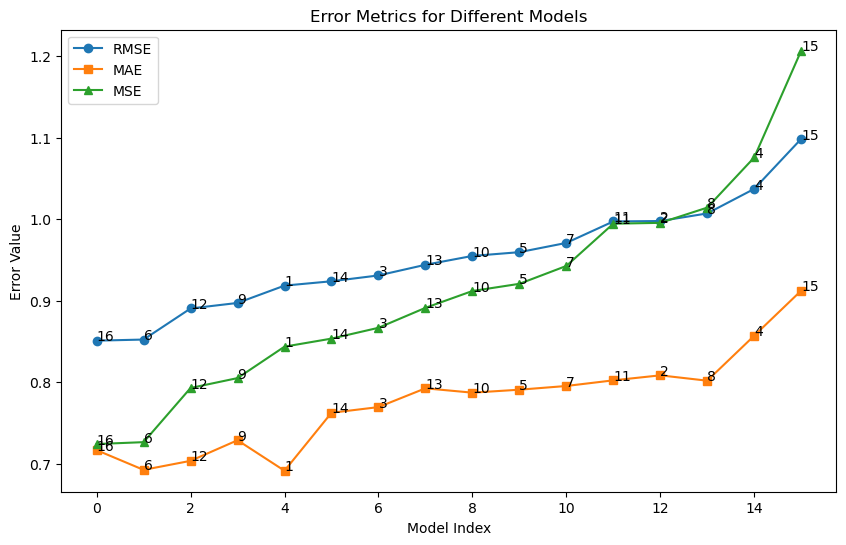

In [21]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MAE'], marker='s', linestyle='-', label='MAE')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MSE'], marker='^', linestyle='-', label='MSE')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MAE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MSE'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

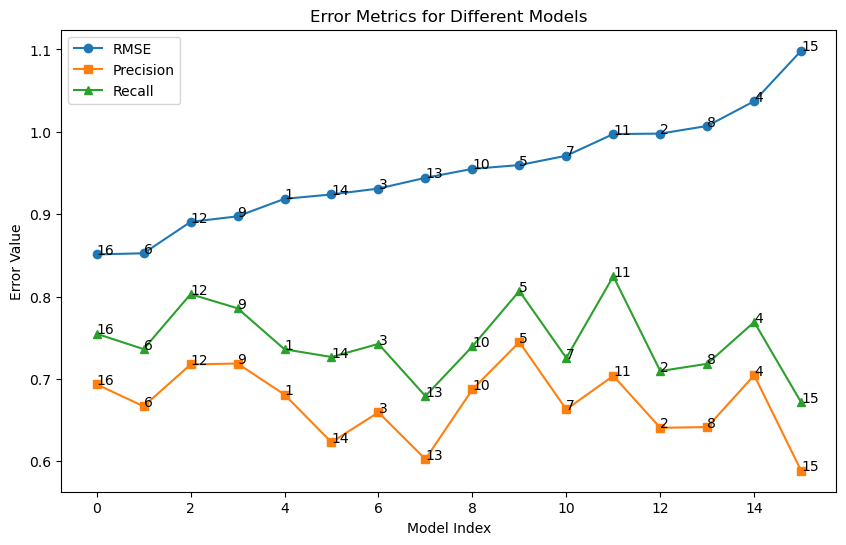

In [22]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Precision'], marker='s', linestyle='-', label='Precision')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Recall'], marker='^', linestyle='-', label='Recall')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Precision'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Recall'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

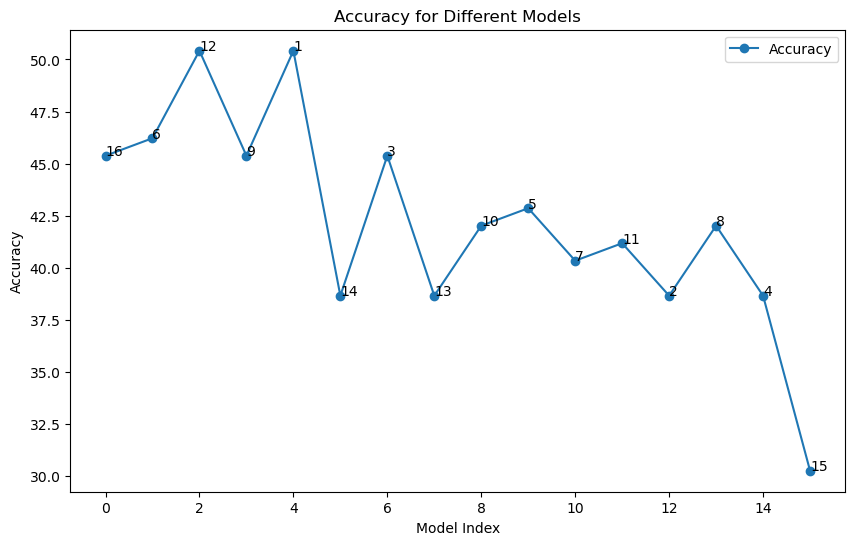

In [23]:
plt.figure(figsize=(10, 6))

#Plot Accuracy with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Accuracy'], marker='o', linestyle='-', label='Accuracy')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Accuracy'].iloc[i]))

#Setting title and labels
plt.title('Accuracy for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Accuracy')

#legend
plt.legend()
plt.show()

## Estimates

In [24]:
knn.estimated(13,20)
print('\n#####\n')
print("Note: If the baseline is {} then the value is a default value, Otherwise not".format(knn.trainset.global_mean))

The 5 nearest neighbors of user 13 are:
user 17 with sim 0.000000000000000
And the baseline estimate is: 4.127427135671926

#####

Note: If the baseline is 3.7007874015748032 then the value is a default value, Otherwise not


In [25]:
df_pred = knn.inspect_predictions(predictions)
best_pred = df_pred.sort_values(by='err')[:10]
worst_pred = df_pred.sort_values(by='err')[-10:]
df_pred.head(10)

uid means the user id and iid means the wine id

rui means the actual rating and est means the estimated rating

err means the error between the actual and the estimated rating

Iu means the number of items rated by given user

Ui means the number of users that have rated given item



,uid,iid,rui,est,details,Iu,Ui,err
0,7a20fe0e-38bf-4e66-967a-dd60aa05d77f,Russiz Superiore,5.0,3.648294,"{'was_impossible': True, 'reason': 'User and/o...",0,0,1.351706
1,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Bakàn,3.0,3.648294,"{'was_impossible': True, 'reason': 'User and/o...",10,0,0.648294
2,a2b48f73-6857-4bcc-a590-6b1ca17dc885,Ginepreta,4.0,3.648294,"{'was_impossible': True, 'reason': 'User and/o...",0,0,0.351706
3,d838a526-4b0a-4fad-b54f-90b6ca321fca,Pinot Noir,3.0,3.648294,"{'was_impossible': True, 'reason': 'User and/o...",2,4,0.648294
4,bc8f3005-c2c6-4277-9fd7-340248f4e7ec,Syrah,4.0,3.648294,"{'was_impossible': True, 'reason': 'User and/o...",7,1,0.351706
5,e2723dcb-0b44-477f-bf74-678640f5c06d,Terrano,5.0,3.648294,"{'was_impossible': True, 'reason': 'User and/o...",1,6,1.351706
6,91cf68cc-9436-43e1-871d-33beef4d2337,Châteauneuf-du-Pape,3.0,3.648294,"{'was_impossible': True, 'reason': 'Not enough...",15,1,0.648294
7,bc79b0e3-064d-4240-86de-e86499f577e8,3／Chevalier de Lascomes,4.0,3.648294,"{'was_impossible': True, 'reason': 'User and/o...",16,1,0.351706
8,5ccd8030-047b-432c-a630-d784ab415756,Cabernet Sauvignon Hainfeld,4.0,3.648294,"{'was_impossible': True, 'reason': 'User and/o...",13,1,0.351706
9,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,Merlot dedica Komjanc,4.0,3.648294,"{'was_impossible': True, 'reason': 'User and/o...",9,1,0.351706


* best predictions

In [26]:
best_pred

,uid,iid,rui,est,details,Iu,Ui,err
113,f9b653da-6c1b-4390-87c6-f74e42bf0a03,Vinho Verde Branco,3.0,3.000000,"{'actual_k': 1, 'was_impossible': False}",2,2,0.000000
49,5ccd8030-047b-432c-a630-d784ab415756,tschiel brut nature,3.0,3.000000,"{'actual_k': 1, 'was_impossible': False}",13,1,0.000000
54,5ccd8030-047b-432c-a630-d784ab415756,Aulerde Riesling,4.0,3.648294,"{'was_impossible': True, 'reason': 'User and/o...",13,0,0.351706
53,13016d41-00bd-411c-83f5-2b95691696b7,Chapel Peak - Fusional of Marlborough,4.0,3.648294,"{'was_impossible': True, 'reason': 'User and/o...",11,1,0.351706
105,4a3e010a-0761-48d4-90c1-b2905e0b7b4a,Voysey pinot gris,4.0,3.648294,"{'was_impossible': True, 'reason': 'User and/o...",3,1,0.351706
50,a965be29-83c9-47b7-a5b3-82d99180cf98,Brut Rosé,4.0,3.648294,"{'was_impossible': True, 'reason': 'User and/o...",0,0,0.351706
95,91cf68cc-9436-43e1-871d-33beef4d2337,Finca Bacara 3015 Jumilla,4.0,3.648294,"{'was_impossible': True, 'reason': 'User and/o...",15,1,0.351706
55,ccdd1b9a-2056-4d76-b922-f427b7932ba7,Casa Rossa Rosso,4.0,3.648294,"{'was_impossible': True, 'reason': 'User and/o...",0,0,0.351706
59,fa623b71-bd8f-47f1-b62b-4a83e6432e02,Nectar dei,4.0,3.648294,"{'was_impossible': True, 'reason': 'User and/o...",1,1,0.351706
107,defee34b-7775-4889-b703-92b730d85e70,Terrarosa,4.0,3.648294,"{'was_impossible': True, 'reason': 'User and/o...",8,0,0.351706


* worst predictions

In [27]:
worst_pred

,uid,iid,rui,est,details,Iu,Ui,err
12,00324bc3-0b35-4051-bc6d-9c258a4252c2,Ettore germano riesling,5.0,3.648294,"{'was_impossible': True, 'reason': 'User and/o...",0,0,1.351706
36,9250d444-805f-4756-a03b-93a597ab320d,Domaine des Granges de Mirabel Coteaux-de-l'Ar...,5.0,3.648294,"{'was_impossible': True, 'reason': 'User and/o...",2,1,1.351706
28,dc90e649-113d-4cec-983e-d03a7d4acff3,Cabernet Sauvignon,5.0,3.648294,"{'was_impossible': True, 'reason': 'User and/o...",1,4,1.351706
26,bc79b0e3-064d-4240-86de-e86499f577e8,3／4 大亂鬥 10,5.0,3.648294,"{'was_impossible': True, 'reason': 'User and/o...",16,0,1.351706
10,7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7,Mendoza Chardonnay,2.0,3.648294,"{'was_impossible': True, 'reason': 'User and/o...",12,1,1.648294
89,91cf68cc-9436-43e1-871d-33beef4d2337,Bella Cabernet Sauvignon,2.0,3.648294,"{'was_impossible': True, 'reason': 'User and/o...",15,1,1.648294
46,91cf68cc-9436-43e1-871d-33beef4d2337,Chardonnay,2.0,3.648294,"{'was_impossible': True, 'reason': 'Not enough...",15,6,1.648294
71,91cf68cc-9436-43e1-871d-33beef4d2337,Gran Malbec,2.0,3.648294,"{'was_impossible': True, 'reason': 'User and/o...",15,1,1.648294
44,876b7023-bbf0-4bd8-a341-61ae5bc4b38f,Signoria Prosecco Extra Dry,2.0,3.648294,"{'was_impossible': True, 'reason': 'User and/o...",0,0,1.648294
38,e5b0e77a-ed45-4436-a771-6e01c5782973,Campofiorin Rosso Veronese,1.0,3.648294,"{'was_impossible': True, 'reason': 'User and/o...",2,1,2.648294
